# Explore here

In [48]:
!pip install missingno lazypredict
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [50]:
df=pd.read_csv('/workspaces/EDA/data/raw/AB_NYC_2019.csv')
pd.set_option('display.max_columns', None)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [51]:
# DImensiones del DF
df.shape

(48895, 16)

In [52]:
# vemos el tipo de cada columna y si hay valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [53]:
#Comprobamos si hay valores únicos en las columnas
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [54]:
print(df.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [55]:
# Aplicar One-Hot Encoding a la columna room_type y eliminamos la columna original
room_type_encoded = pd.get_dummies(df['room_type'], prefix='room_type')
df = pd.concat([df, room_type_encoded], axis=1)

df.drop('room_type', axis=1, inplace=True)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,149,1,9,2018-10-19,0.21,6,365,False,True,False
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,225,1,45,2019-05-21,0.38,2,355,True,False,False
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,150,3,0,NaN,NaN,1,365,False,True,False
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,89,1,270,2019-07-05,4.64,1,194,True,False,False
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,80,10,9,2018-11-19,0.10,1,0,True,False,False


In [56]:
# Repetimos el proceso en la columna neighbourhood_group
neighbourhood_group_encoded = pd.get_dummies(df['neighbourhood_group'], prefix='neighbourhood_group')
df = pd.concat([df,neighbourhood_group_encoded], axis=1)

df.drop('neighbourhood_group', axis=1, inplace=True)
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.65,-73.97,149,1,9,2018-10-19,0.21,6,365,False,True,False,False,True,False,False,False
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75,-73.98,225,1,45,2019-05-21,0.38,2,355,True,False,False,False,False,True,False,False
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.81,-73.94,150,3,0,NaN,NaN,1,365,False,True,False,False,False,True,False,False
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.69,-73.96,89,1,270,2019-07-05,4.64,1,194,True,False,False,False,True,False,False,False
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.80,-73.94,80,10,9,2018-11-19,0.10,1,0,True,False,False,False,False,True,False,False


In [57]:
# ELiminiamos las columnas que no nos apostan informacion relevante
df.columns
df.drop (['name','host_id','id','host_name','last_review','reviews_per_month','neighbourhood'] , axis=1, inplace= True)
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           48895 non-null  float64
 1   longitude                          48895 non-null  float64
 2   price                              48895 non-null  int64  
 3   minimum_nights                     48895 non-null  int64  
 4   number_of_reviews                  48895 non-null  int64  
 5   calculated_host_listings_count     48895 non-null  int64  
 6   availability_365                   48895 non-null  int64  
 7   room_type_Entire home/apt          48895 non-null  bool   
 8   room_type_Private room             48895 non-null  bool   
 9   room_type_Shared room              48895 non-null  bool   
 10  neighbourhood_group_Bronx          48895 non-null  bool   
 11  neighbourhood_group_Brooklyn       48895 non-null  boo

In [58]:
#Revismaos que no haya anuncios duplicados
df.duplicated().sum()

np.int64(0)

In [59]:
#Descripción de las columnas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,48895.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
price,48895.00,152.72,240.15,0.00,69.00,106.00,175.00,10000.00
minimum_nights,48895.00,7.03,20.51,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,48895.00,23.27,44.55,0.00,1.00,5.00,24.00,629.00
calculated_host_listings_count,48895.00,7.14,32.95,1.00,1.00,1.00,2.00,327.00
availability_365,48895.00,112.78,131.62,0.00,0.00,45.00,227.00,365.00


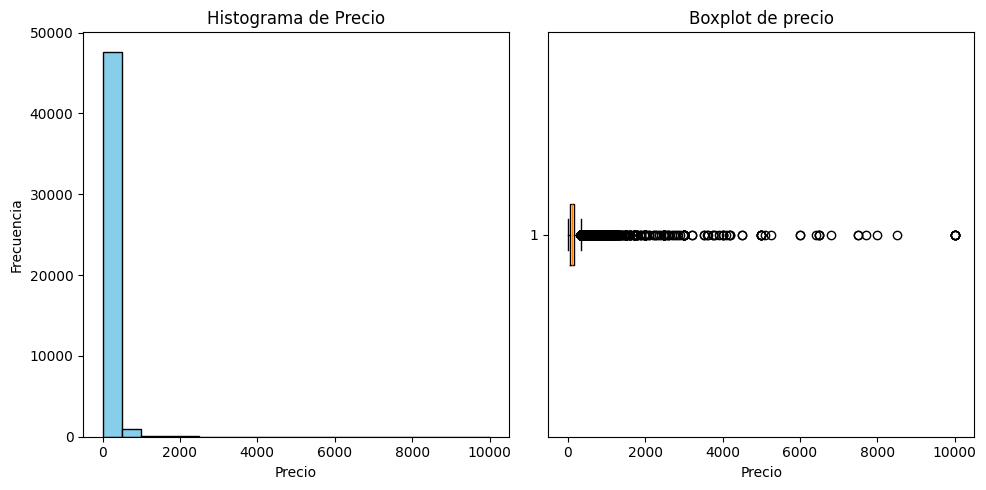

In [60]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de precio')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [61]:
# Transformamos nuestro target a escala logarítmica y limpiamos los valores no finitos para poder graficar
df['log_price'] = np.log(df['price'])
df = df[np.isfinite(df['log_price'])]

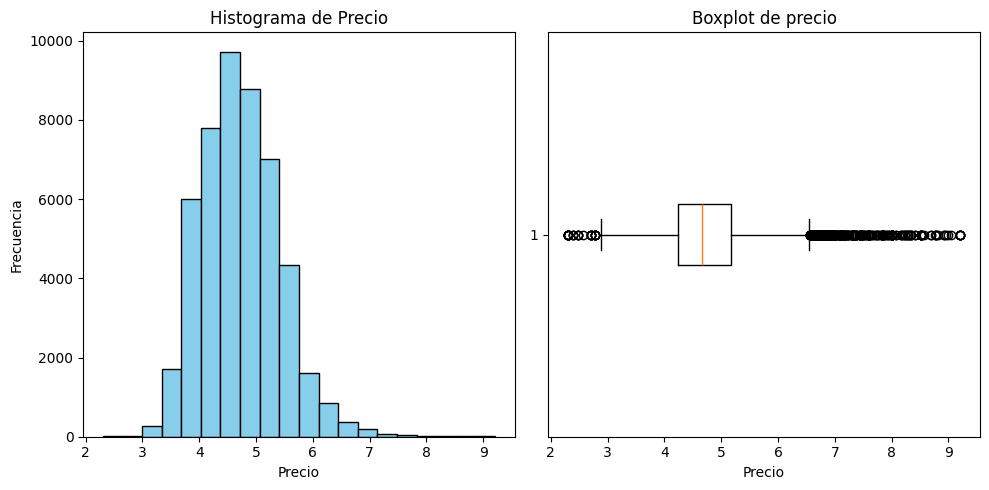

In [62]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Crear un histograma en el primer subplot
ax[0].hist(df['log_price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['log_price'], vert=False)
ax[1].set_title('Boxplot de precio')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [63]:
# Revisamos si hay valores faltantes
df.isnull().mean()*100

latitude                            0.00
longitude                           0.00
price                               0.00
minimum_nights                      0.00
number_of_reviews                   0.00
calculated_host_listings_count      0.00
availability_365                    0.00
room_type_Entire home/apt           0.00
room_type_Private room              0.00
room_type_Shared room               0.00
neighbourhood_group_Bronx           0.00
neighbourhood_group_Brooklyn        0.00
neighbourhood_group_Manhattan       0.00
neighbourhood_group_Queens          0.00
neighbourhood_group_Staten Island   0.00
log_price                           0.00
dtype: float64

<Axes: >

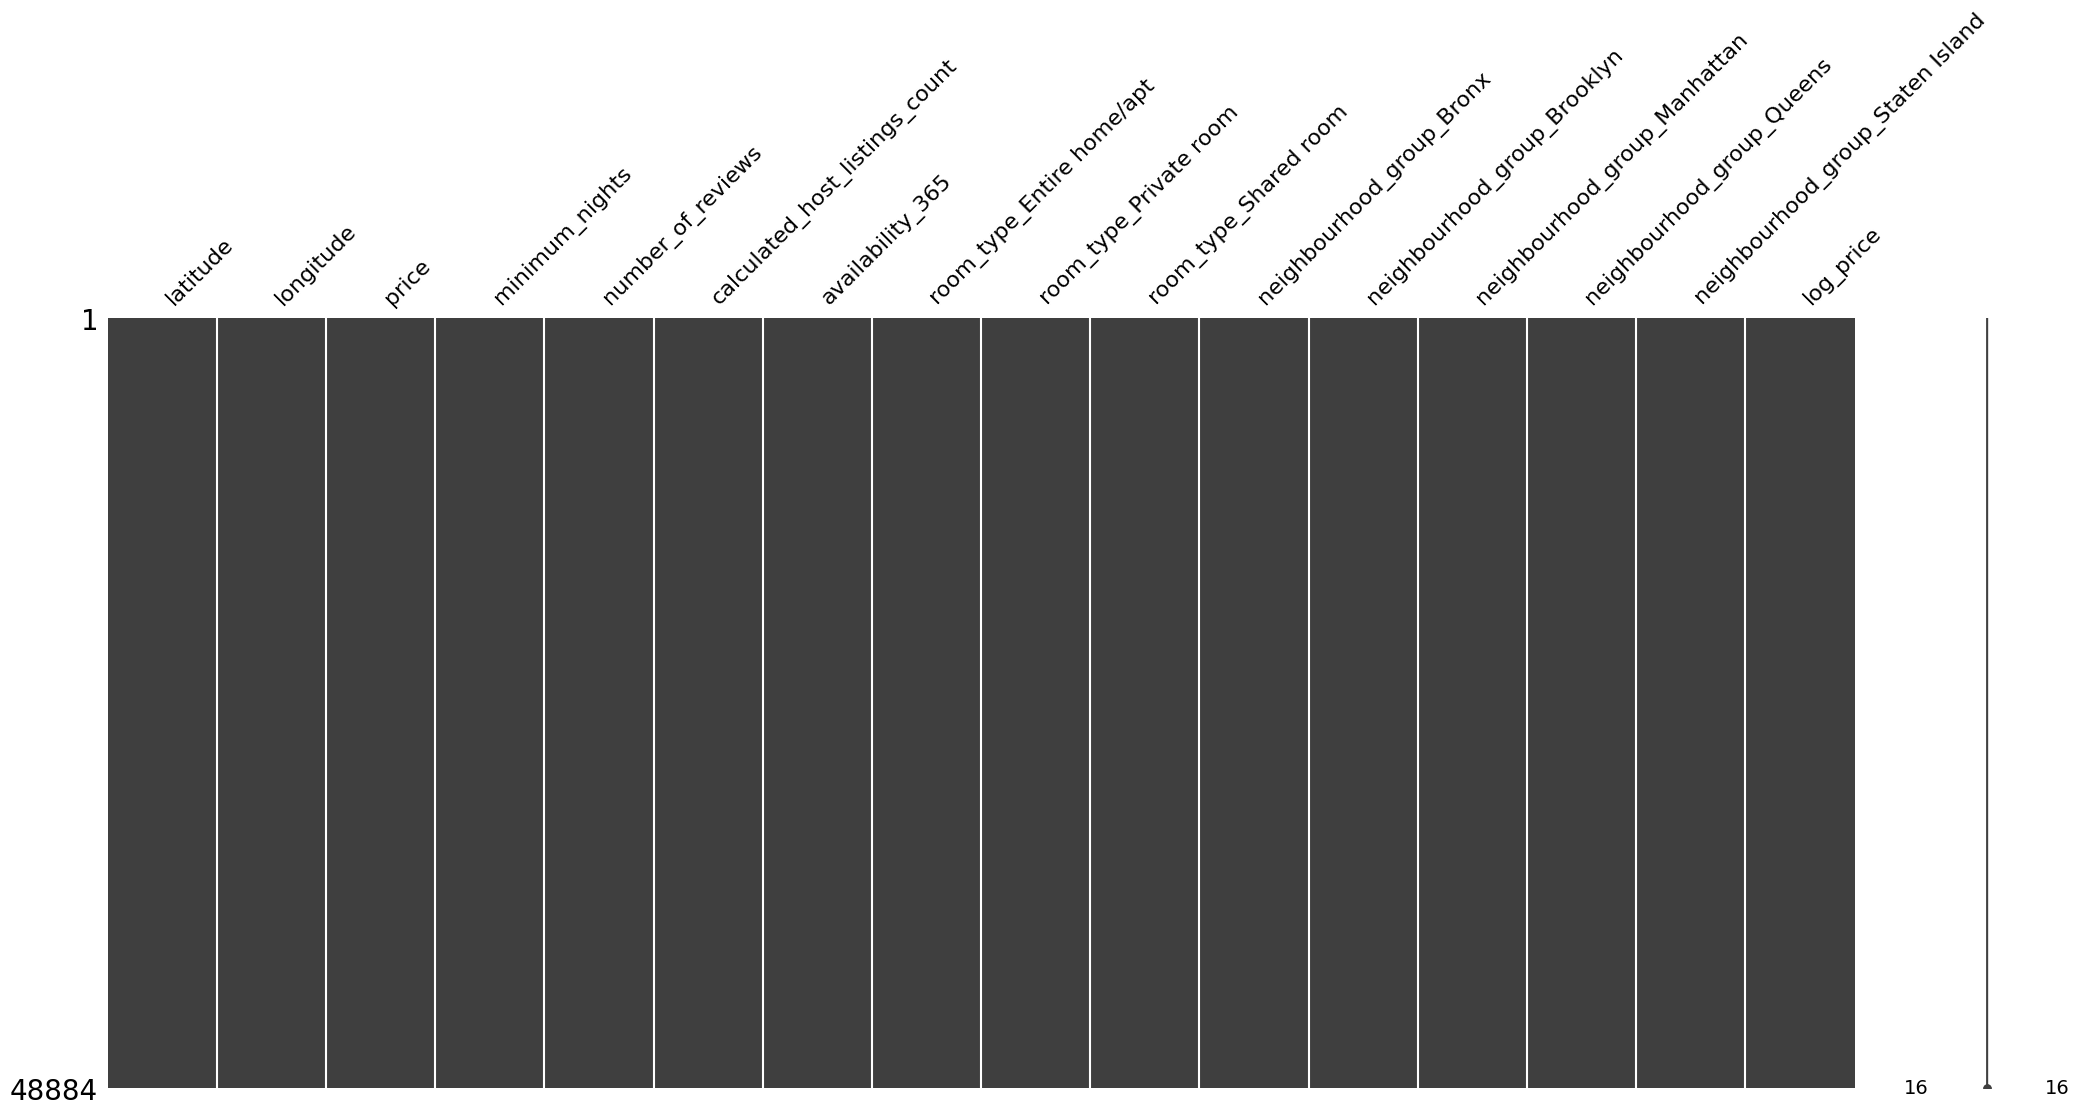

In [64]:
msno.matrix(df)

Al no haber valores faltantes en ninguna de las categorías que estamos obervando, no aparecen espacios en blanco en ninguna de ellas. Debido a esto, no es necesario utilizar el algoritmo knn.

In [65]:
X = df.drop(['price', 'log_price'], axis = 1)
y = df['log_price']

# Covnertimos las columnas booleanas en float para evitar error (dtype_object) al ajecutar la celda
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool'].astype(float)

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
cooks_distance = model.get_influence().cooks_distance


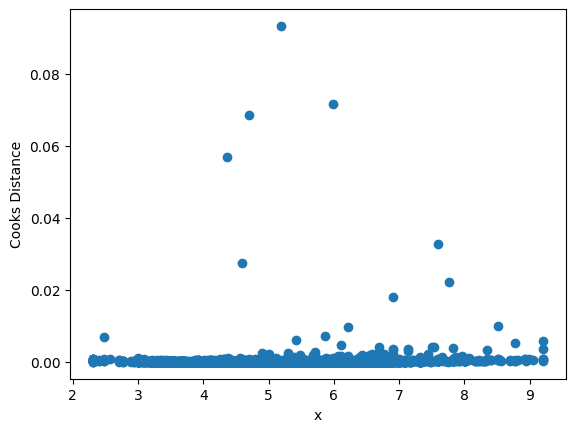

In [66]:
plt.scatter(df['log_price'], cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [67]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

1819

In [68]:
np.where(cooks_distance[0]>0.08)

(array([5767]),)

In [69]:
# Vemos los datos de nuestro punto más alejado 

df.iloc[5767,]

latitude                             40.73
longitude                           -74.00
price                                  180
minimum_nights                        1250
number_of_reviews                        2
calculated_host_listings_count           1
availability_365                       365
room_type_Entire home/apt             True
room_type_Private room               False
room_type_Shared room                False
neighbourhood_group_Bronx            False
neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan         True
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
log_price                             5.19
Name: 5767, dtype: object

In [71]:
# Eliminar observaciones que se consideran influentes
df = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

In [ ]:
#Comprobamos si hay duplicados
df.duplicated().sum()

np.int64(0)

In [73]:
#Partición de los datos en test y train
X = df.drop(['price', 'log_price'], axis = 1)
y = df['log_price']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)